<a href="https://colab.research.google.com/github/Jarnoesse/IA-AGN-with-ML/blob/main/classifier_regressor_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data importation
This section was taken from Pedro Ferreira's notebook

In [146]:
#import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_log_error, plot_confusion_matrix, classification_report, explained_variance_score

from pandas.plotting import scatter_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

import missingno as msno

plt.style.use('seaborn')


import os.path

In [147]:
#download datasets
table_des_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_DES_specZ_milliquas_basicFeatures.csv'
table_des_cat = Table.read(table_des_catalogue_URL)

des_df = table_des_cat.to_pandas()

table_ps_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_PS_specZ_milliquas_basicFeatures.csv'
table_ps_cat = Table.read(table_ps_catalogue_URL)

ps_df = table_ps_cat.to_pandas()

table_sm_catalogue_URL = 'http://oal.ul.pt/data/AlmaQA2/Catalogs_cV1ax509ZbXXx978pb3/RACS_VEXAS_ALLWISE_SM_specZ_milliquas_basicFeatures.csv'
table_sm_cat = Table.read(table_sm_catalogue_URL)

sm_df = table_sm_cat.to_pandas()

In [148]:
#feature preparation for the first dataset
des_df['W1-W2'] = des_df['W1MAG']-des_df['W2MAG']
des_df['J-KS'] = des_df['J_VISTA']-des_df['KS_VISTA']
des_df['KS-W1'] = des_df['KS_VISTA']-des_df['W1MAG']
des_df['G-R'] = des_df['MAG_G']-des_df['MAG_R']
des_df['R-Z'] = des_df['MAG_R']-des_df['MAG_Z']
des_df['Z-J'] = des_df['MAG_Z']-des_df['J_VISTA']
des_df['G-RadioR'] = des_df['MAG_G']-des_df['flux_int']
des_df['W2-RadioR'] = des_df['W2MAG']-des_df['flux_int']

#feature preparation for the second dataset
ps_df['W1-W2'] = ps_df['W1MAG']-ps_df['W2MAG']
ps_df['J-KS'] = ps_df['J_VISTA']-ps_df['KS_VISTA']
ps_df['KS-W1'] = ps_df['KS_VISTA']-ps_df['W1MAG']
ps_df['G-R'] = ps_df['MAG_G']-ps_df['MAG_R']
ps_df['R-Z'] = ps_df['MAG_R']-ps_df['MAG_Z']
ps_df['Z-J'] = ps_df['MAG_Z']-ps_df['J_VISTA']
ps_df['G-RadioR'] = ps_df['MAG_G']-ps_df['flux_int']
ps_df['W2-RadioR'] = ps_df['W2MAG']-ps_df['flux_int']

#feature preparation for the third dataset
sm_df['W1-W2'] = sm_df['W1MAG']-sm_df['W2MAG']
sm_df['J-KS'] = sm_df['J_VISTA']-sm_df['KS_VISTA']
sm_df['KS-W1'] = sm_df['KS_VISTA']-sm_df['W1MAG']
sm_df['U-G'] = sm_df['MAG_U']-sm_df['MAG_G']
sm_df['G-R'] = sm_df['MAG_G']-sm_df['MAG_R']
sm_df['R-Z'] = sm_df['MAG_R']-sm_df['MAG_Z']
sm_df['Z-J'] = sm_df['MAG_Z']-sm_df['J_VISTA']
sm_df['G-RadioR'] = sm_df['MAG_G']-sm_df['flux_int']
sm_df['W2-RadioR'] = sm_df['W2MAG']-sm_df['flux_int']

In [149]:
#TSNE was used in the test fases of this project but never used again LOOK FOR DELETE
from sklearn.manifold import TSNE
from sklearn import preprocessing

In [150]:
#creation of the dataframe with the desired features, such features as ID or position are not important for the goals of this experiment.
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","PSTAR_VISTA","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR","spec_class","z_spec"]
ps_df = ps_df[attributes]

Neural Networks

Keras model

In [151]:
#import of the keras / skit-learn libraries useful for this project
from numpy import unique
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow import keras

In [152]:
df_sample = ps_df.dropna() #creating the sample dataframe dropping the NaN columns from the PS dataframe

In [153]:
pd.options.mode.chained_assignment = None  # default='warn'

In [154]:
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","PSTAR_VISTA","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
#converting the dataframe into a numpy array for better handling by Keras
dataset = df_sample[attributes].to_numpy()

Regressor

In [155]:
#defining the y test
y_test = df_sample["z_spec"].values

#converting everything to float
dataset, y_test = dataset.astype("float"), y_test.astype("float")

In [156]:
n_features = dataset.shape[1]

#splitting the train and the test set
X_train, X_test, y_train, y_test = train_test_split(dataset, y_test, test_size=0.33, random_state=1)


In [157]:
#defining the Keras model for regression

visible = Input(shape=(n_features,))
hidden1 = Dense(500, activation='relu', kernel_initializer='he_normal')(visible)
dropout1 = Dropout(0.2)(hidden1)
hidden3 = Dense(500, activation = "relu", kernel_initializer="he_normal")(dropout1)
dropout3 = Dropout(0.2)(hidden3)
hidden2 = Dense(500, activation='relu', kernel_initializer='he_normal')(dropout1)
dropout2 = Dropout(0.2)(hidden3)


In [158]:
#defining the out layer
out_reg = Dense(1, activation='linear')(dropout2)

#defining the model
model1 = Model(inputs=visible, outputs=[out_reg])

#compiling the Keras regression model with sparse categorical crossentropy and adam optimizer 0.02
model1.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

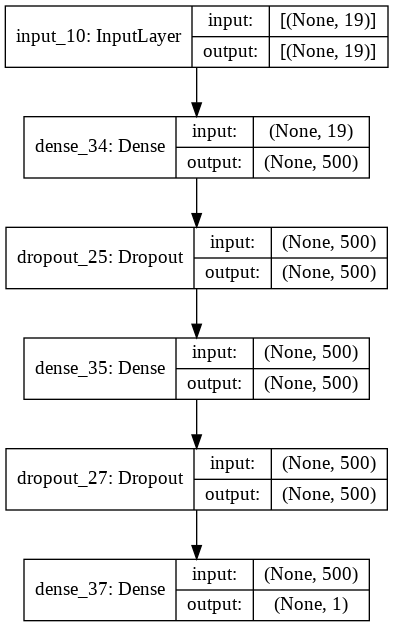

In [159]:
# plot graph of model
plot_model(model1, to_file='model.png', show_shapes=True)

In [160]:
#fitting the regression model
model1.fit(X_train,y_train, epochs=300, batch_size=32, verbose=2) # time consuming!!!!!

Epoch 1/300
282/282 - 2s - loss: 54.7234
Epoch 2/300
282/282 - 1s - loss: 2.6508
Epoch 3/300
282/282 - 2s - loss: 0.6444
Epoch 4/300
282/282 - 1s - loss: 0.3594
Epoch 5/300
282/282 - 1s - loss: 0.2846
Epoch 6/300
282/282 - 1s - loss: 0.2520
Epoch 7/300
282/282 - 2s - loss: 0.2270
Epoch 8/300
282/282 - 1s - loss: 0.2079
Epoch 9/300
282/282 - 1s - loss: 0.1894
Epoch 10/300
282/282 - 1s - loss: 0.1752
Epoch 11/300
282/282 - 1s - loss: 0.1625
Epoch 12/300
282/282 - 1s - loss: 0.1604
Epoch 13/300
282/282 - 2s - loss: 0.1479
Epoch 14/300
282/282 - 1s - loss: 0.1488
Epoch 15/300
282/282 - 1s - loss: 0.1453
Epoch 16/300
282/282 - 1s - loss: 0.1441
Epoch 17/300
282/282 - 1s - loss: 0.1390
Epoch 18/300
282/282 - 1s - loss: 0.1402
Epoch 19/300
282/282 - 1s - loss: 0.1353
Epoch 20/300
282/282 - 1s - loss: 0.1331
Epoch 21/300
282/282 - 1s - loss: 0.1283
Epoch 22/300
282/282 - 1s - loss: 0.1274
Epoch 23/300
282/282 - 1s - loss: 0.1315
Epoch 24/300
282/282 - 1s - loss: 0.1214
Epoch 25/300
282/282 - 1

In [161]:
#calculating model predictions
yhat1 = model1.predict(X_test)

#evaluating the model
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.095


Skit-learn regression




In [162]:
#importing the regressor
from sklearn.linear_model import LinearRegression

In [163]:
#defining the regressor
reg = LinearRegression().fit(X_train,y_train)
yhat1 = reg.predict(X_test)

#evaluating the error
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.162


Classificator

In [164]:
#creating the sample dataframe for the classification
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","PSTAR_VISTA","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]

#predicting the zspec with the previous model
df_sample["z_spec_1"] = model1.predict(df_sample[attributes].to_numpy())

#creating the final sample numpy array from the dataframe
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","PSTAR_VISTA","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR","z_spec_1"]
dataset = df_sample[attributes].to_numpy()

In [165]:
#defining the class array
y_class = df_sample["spec_class"].values

#seeing how many classes we have (3)
n_class = len(unique(y_class))

#converting everything to float as before
dataset,  y_class = dataset.astype('float'),y_class.astype("int")

In [166]:
#importing the oversampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [167]:
#counting how many classes we do have and how many instances
Counter(y_class)

Counter({0: 84, 1: 2751, 2: 10629})

In [168]:
#defining the number of features
n_features = dataset.shape[1]

#splitting training and test datasets
X_train, X_test, y_train_class, y_test_class = train_test_split(dataset, y_class, test_size=0.33, random_state=1)


In [169]:
#quick count of the instances in the train set
Counter(y_train_class) 

Counter({0: 67, 1: 1854, 2: 7099})

In [170]:
#defining oversampling strategy
sampling_strategy_  = {0: 3000,
                      1: 7099,
                      2: 7099}

#oversampling training set
ros = RandomOverSampler(random_state=42,sampling_strategy=sampling_strategy_)
X_train, y_train_class = ros.fit_resample(X_train, y_train_class)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [171]:
#defining keras regressor (later i'll use random forest one)
visible = Input(shape=(n_features,))
hidden1 = Dense(500, activation='relu', kernel_initializer='he_normal')(visible)
dropout1 = Dropout(0.3)(hidden1)
hidden3 = Dense(500, activation='relu', kernel_initializer='he_normal')(dropout1)
dropout3 = Dropout(0.3)(hidden2)
hidden2 = Dense(500, activation='relu', kernel_initializer='he_normal')(dropout3)
dropout2 = Dropout(0.3)(hidden2)

out_clas = Dense(3, activation='sigmoid')(dropout2)

In [172]:
model2 = Model(inputs=visible, outputs=[out_clas])

model2.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

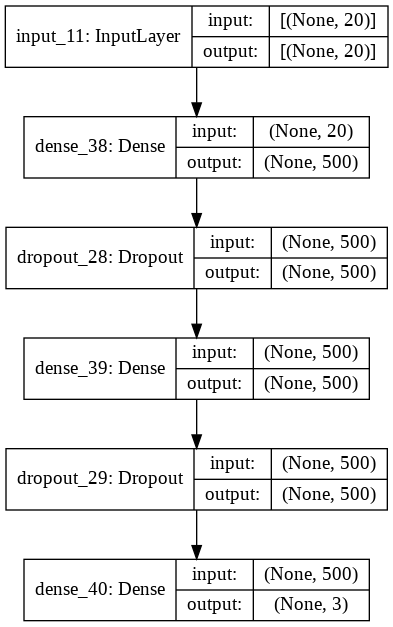

In [173]:
# plot graph of model
plot_model(model2, to_file='model.png', show_shapes=True)

In [174]:
#fitting keras classifier
model2.fit(X_train,y_train_class, epochs=300, batch_size=32, verbose=2)


538/538 - 3s - loss: 0.5880


In [175]:
#evaluating accuracy
yhat2 = model2.predict(X_test)
yhat2 = argmax(yhat2, axis=-1).astype('int')
acc = accuracy_score(y_test_class, yhat2)
print('Accuracy: %.3f' % acc)

Accuracy: 0.004


In [176]:
#confusion matrix
confusion_matrix(y_test_class,yhat2)

array([[  17,    0,    0],
       [ 897,    0,    0],
       [3530,    0,    0]])

Random forest

In [177]:
#importing random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [178]:
#defining and fitting RFClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train_class)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [179]:
#evaluating the model
yhat2 = clf.predict(X_test)
confusion_matrix(y_test_class,yhat2)

array([[  16,    0,    1],
       [   0,  723,  174],
       [   1,  184, 3345]])

data managing

In [180]:
#defining the dataset where we make the predictions
null_1 = ps_df[ps_df["z_spec"].isnull()]
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z","PSTAR_VISTA","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
null_1 = null_1[attributes]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f92abeef2d0>,
      dtype=object)

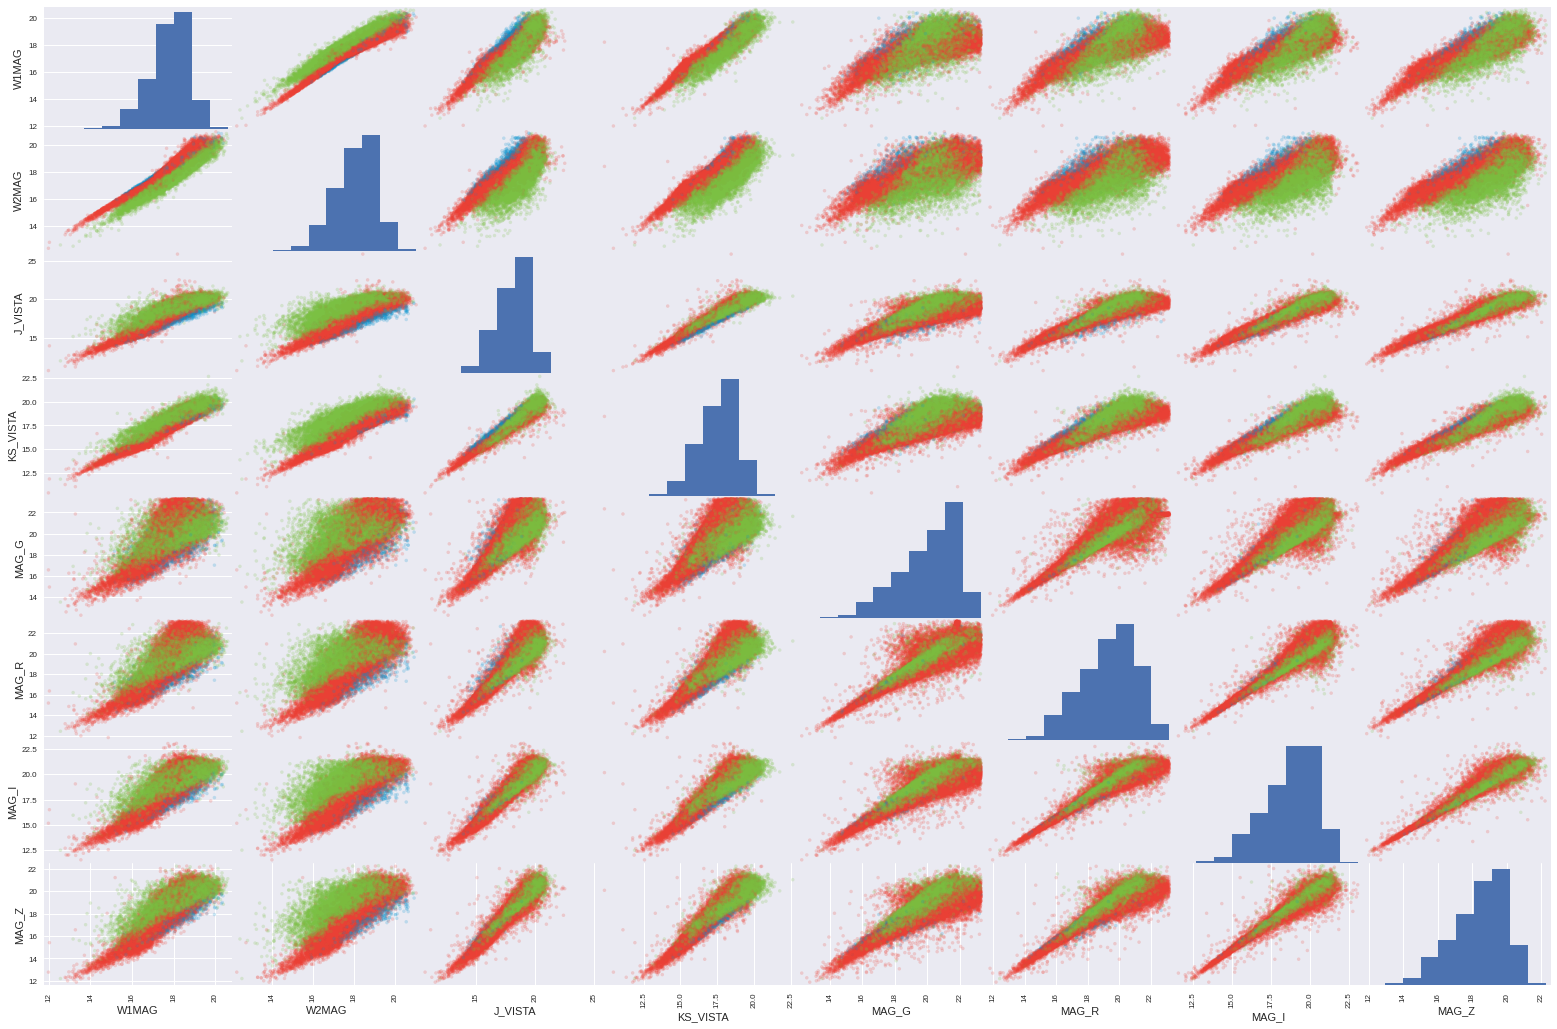

In [181]:
#predictiong the redshifts
predicted_redshifts = model1.predict(null_1.values)

#saving redshift values
null_1["z_spec"] = predicted_redshifts

#predicting the classes
predicted_classes = clf.predict(null_1.values)

#saving the predicted classes
null_1["z_class"] = predicted_classes

#defining the colormap
color_wheel = {0: "#0392cf", #blue Star
               1: "#7bc043", #green AGN
               2: "#ee4035"} #red Galaxy
colors = null_1["z_class"].map(lambda x: color_wheel.get(x))

#plotting the scatter matrices
attributes = ["W1MAG","W2MAG","J_VISTA","KS_VISTA","MAG_G","MAG_R","MAG_I","MAG_Z"]
scatter_matrix(null_1[attributes],color = colors, figsize=(27,18),alpha = 0.2)

In [182]:
#counting the classes of our prediction
null_1["z_class"].value_counts()

2    45628
1    11521
0      900
Name: z_class, dtype: int64

DES CATALOGUE

In [183]:
des_df

,col0,catalogue_id,n_components,flux_int,flux_peak,quality_level,SOURCEID_VISTA,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_G,MAG_R,MAG_I,MAG_Z,z_spec,spec_class,W1-W2,J-KS,KS-W1,G-R,R-Z,Z-J,G-RadioR,W2-RadioR
0,2,1542,1,15.087712,15.005931,"b""b'NOT_VALIDATED'""",472906754566,15.582000,15.717,15.234133,14.885287,0.000171,16.596,15.817,15.492,15.222,0.062,1,-0.135000,0.348846,-0.696713,0.779,0.595,-0.012133,1.508288,0.629288
1,10,783,1,14.791615,15.142908,"b""b'NOT_VALIDATED'""",472906735951,16.441000,16.106,17.142910,16.910446,0.052478,17.561,17.526,17.507,17.502,0.723,1,0.334999,0.232464,0.469447,0.035,0.024,0.359090,2.769385,1.314385
2,13,1377,1,13.793266,13.862125,"b""b'NOT_VALIDATED'""",472681339854,19.573001,19.623,19.522250,19.605973,0.052478,20.136,19.883,19.735,19.732,3.061,1,-0.050000,-0.083723,0.032972,0.253,0.151,0.209750,6.342734,5.829734
3,14,97,1,13.474419,13.774631,"b""b'NOT_VALIDATED'""",472890266372,18.098000,17.416,17.961023,18.245827,0.993865,17.905,17.771,17.820,17.885,NaN,<NA>,0.682001,-0.284804,0.147827,0.134,-0.114,-0.076023,4.430581,3.941581
4,15,44,1,18.826541,14.740983,"b""b'UNCERTAIN '""",473426008788,17.230000,17.017,17.044435,16.486081,0.003067,18.515,17.967,17.429,17.219,NaN,<NA>,0.213000,0.558354,-0.743919,0.548,0.748,0.174565,-0.311541,-1.809540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175749,259245,675,1,15.166006,15.044805,"b""b'NOT_VALIDATED'""",473340908930,17.226000,17.430,16.921362,16.488793,0.000171,19.306,18.101,17.661,17.388,0.279,1,-0.203999,0.432569,-0.737207,1.205,0.713,0.466638,4.139994,2.263993
175750,259246,2281,1,11.623332,11.657555,"b""b'NOT_VALIDATED'""",473200338277,16.889000,16.816,16.904316,16.434285,0.003067,19.288,18.053,17.607,17.442,NaN,<NA>,0.072999,0.470031,-0.454715,1.235,0.611,0.537684,7.664668,5.192668
175751,259247,1484,1,15.057342,14.844983,"b""b'NOT_VALIDATED'""",472854980131,14.490000,13.830,17.293708,15.488930,0.486486,19.174,18.304,17.976,17.829,NaN,<NA>,0.660000,1.804778,0.998930,0.870,0.475,0.535292,4.116658,-1.227342
175752,259249,2758,1,16.405442,15.796757,"b""b'NOT_VALIDATED'""",472602670940,17.321000,16.871,17.172320,17.063626,0.003067,18.257,17.758,17.597,17.445,NaN,<NA>,0.450000,0.108694,-0.257374,0.499,0.313,0.272680,1.851558,0.465557


In [184]:
attributes = ["flux_int","flux_peak","MAG_I","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR","spec_class","z_spec"]
des_df = des_df[attributes]
df_sample = des_df.dropna()
attributes = ["flux_int","flux_peak","MAG_I","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
dataset = df_sample[attributes].to_numpy()

In [185]:
y_sample = df_sample["z_spec"].values
dataset, y_test = dataset.astype("float"), y_test.astype("float")
n_features = dataset.shape[1]
X_train, X_test, y_train, y_test = train_test_split(dataset, y_sample, test_size=0.33, random_state=1)

In [188]:
visible = Input(shape=(n_features,))
hidden1 = Dense(500, activation='relu', kernel_initializer='he_normal')(visible)
dropout1 = Dropout(0.2)(hidden1)
hidden3 = Dense(500, activation = "relu", kernel_initializer="he_normal")(dropout1)
dropout3 = Dropout(0.2)(hidden3)
hidden2 = Dense(500, activation='relu', kernel_initializer='he_normal')(dropout1)
dropout2 = Dropout(0.2)(hidden2)

out_reg = Dense(1, activation='linear')(dropout2)

model1 = Model(inputs=visible, outputs=[out_reg])

model1.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

In [189]:
model1.fit(X_train,y_train, epochs=300, batch_size=32, verbose=2)

Epoch 1/300
263/263 - 2s - loss: 44.3708
Epoch 2/300
263/263 - 1s - loss: 3.4241
Epoch 3/300
263/263 - 1s - loss: 0.7658
Epoch 4/300
263/263 - 1s - loss: 0.3030
Epoch 5/300
263/263 - 1s - loss: 0.2249
Epoch 6/300
263/263 - 1s - loss: 0.1949
Epoch 7/300
263/263 - 1s - loss: 0.1766
Epoch 8/300
263/263 - 1s - loss: 0.1531
Epoch 9/300
263/263 - 1s - loss: 0.1410
Epoch 10/300
263/263 - 1s - loss: 0.1349
Epoch 11/300
263/263 - 1s - loss: 0.1257
Epoch 12/300
263/263 - 1s - loss: 0.1239
Epoch 13/300
263/263 - 1s - loss: 0.1185
Epoch 14/300
263/263 - 1s - loss: 0.1175
Epoch 15/300
263/263 - 1s - loss: 0.1131
Epoch 16/300
263/263 - 1s - loss: 0.1107
Epoch 17/300
263/263 - 1s - loss: 0.1073
Epoch 18/300
263/263 - 1s - loss: 0.1065
Epoch 19/300
263/263 - 1s - loss: 0.1033
Epoch 20/300
263/263 - 1s - loss: 0.0998
Epoch 21/300
263/263 - 1s - loss: 0.1008
Epoch 22/300
263/263 - 1s - loss: 0.0963
Epoch 23/300
263/263 - 1s - loss: 0.0998
Epoch 24/300
263/263 - 1s - loss: 0.0958
Epoch 25/300
263/263 - 1

In [190]:
yhat1 = model1.predict(X_test)
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.094


In [191]:
reg = LinearRegression().fit(X_train,y_train)

yhat1 = reg.predict(X_test)

error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.185


In [192]:
attributes = ["flux_int","flux_peak","MAG_I","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
df_sample["z_spec_1"] = model1.predict(df_sample[attributes].to_numpy())
attributes = ["flux_int","flux_peak","MAG_I","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR","z_spec_1"]
dataset = df_sample[attributes].to_numpy()

In [193]:
y_class = df_sample["spec_class"].values
n_class = len(unique(y_class))
dataset,  y_class = dataset.astype('float'),y_class.astype("int")

In [194]:
n_features = dataset.shape[1]
X_train, X_test, y_train_class, y_test_class = train_test_split(dataset, y_class, test_size=0.33, random_state=1)


In [195]:
Counter(y_train_class)

Counter({0: 46, 1: 1251, 2: 7096})

In [196]:
sampling_strategy_  = {0: 2000,
                      1: 5096,
                      2: 7096}

ros = RandomOverSampler(random_state=42,sampling_strategy=sampling_strategy_)
X_train, y_train_class = ros.fit_resample(X_train, y_train_class)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [197]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train_class)
yhat2 = clf.predict(X_test)

In [198]:
confusion_matrix(y_test_class,yhat2)

array([[  13,    2,    8],
       [   0,  503,  107],
       [   3,  134, 3365]])

In [199]:
null_2 = ps_df[des_df["z_spec"].isnull()]
attributes = ["flux_int","flux_peak","MAG_I","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
null_2 = null_2[attributes]

predicted_redshifts = model1.predict(null_2.values)

null_2["z_spec"] = predicted_redshifts

predicted_classes = clf.predict(null_2.values)

null_2["z_class"] = predicted_classes

color_wheel = {0: "#0392cf", #blue Star
               1: "#7bc043", #green AGN
               2: "#ee4035"} #red Galaxy
colors = null_2["z_class"].map(lambda x: color_wheel.get(x))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [200]:
null_2

,flux_int,flux_peak,MAG_I,MAG_R,MAG_G,MAG_Z,W1-W2,J-KS,KS-W1,G-R,R-Z,Z-J,G-RadioR,W2-RadioR,z_spec,z_class
3,12.600692,12.604439,20.0435,20.2113,19.9939,19.7645,-0.083000,0.616855,-0.052147,-0.2174,0.4468,-0.026208,7.393208,6.708308,2.081135,1
4,15.417818,15.128676,18.3317,18.7711,19.7773,17.9279,-0.392999,0.473922,-0.738322,1.0062,0.8432,0.294300,4.359482,2.873182,0.202073,2
5,14.552652,14.587673,18.2139,18.2598,18.2794,18.2575,0.657999,-0.020713,0.546390,0.0196,0.0023,-0.096177,3.726748,2.617348,1.341661,1
8,13.793266,13.862125,19.9381,19.9366,20.0487,19.8634,-0.050000,-0.083723,0.032972,0.1121,0.0732,0.341150,6.255434,5.829734,3.061667,1
9,13.474419,13.774631,18.0120,18.1005,18.2178,18.1395,0.682001,-0.284804,0.147827,0.1173,-0.0390,0.178477,4.743381,3.941581,1.547785,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71508,13.890164,13.856373,18.9779,18.8057,19.0425,18.8010,0.355001,0.046159,0.377696,0.2368,0.0047,0.295145,5.152336,3.836835,1.424169,1
71509,13.580781,13.540902,17.5284,17.9213,18.9500,17.2462,-0.184000,0.366510,-0.788518,1.0287,0.6751,0.443208,5.369219,3.828219,0.212084,1
71510,13.920274,13.833769,18.3550,18.8655,19.9359,18.0672,0.197000,0.475127,0.228450,1.0704,0.7983,0.527623,6.015626,2.718726,0.752306,1
71511,15.166006,15.044805,17.6677,18.1093,19.3401,17.2037,-0.203999,0.432569,-0.737207,1.2308,0.9056,0.282338,4.174094,2.263993,0.225633,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f92b241c5d0>,
      dtype=object)

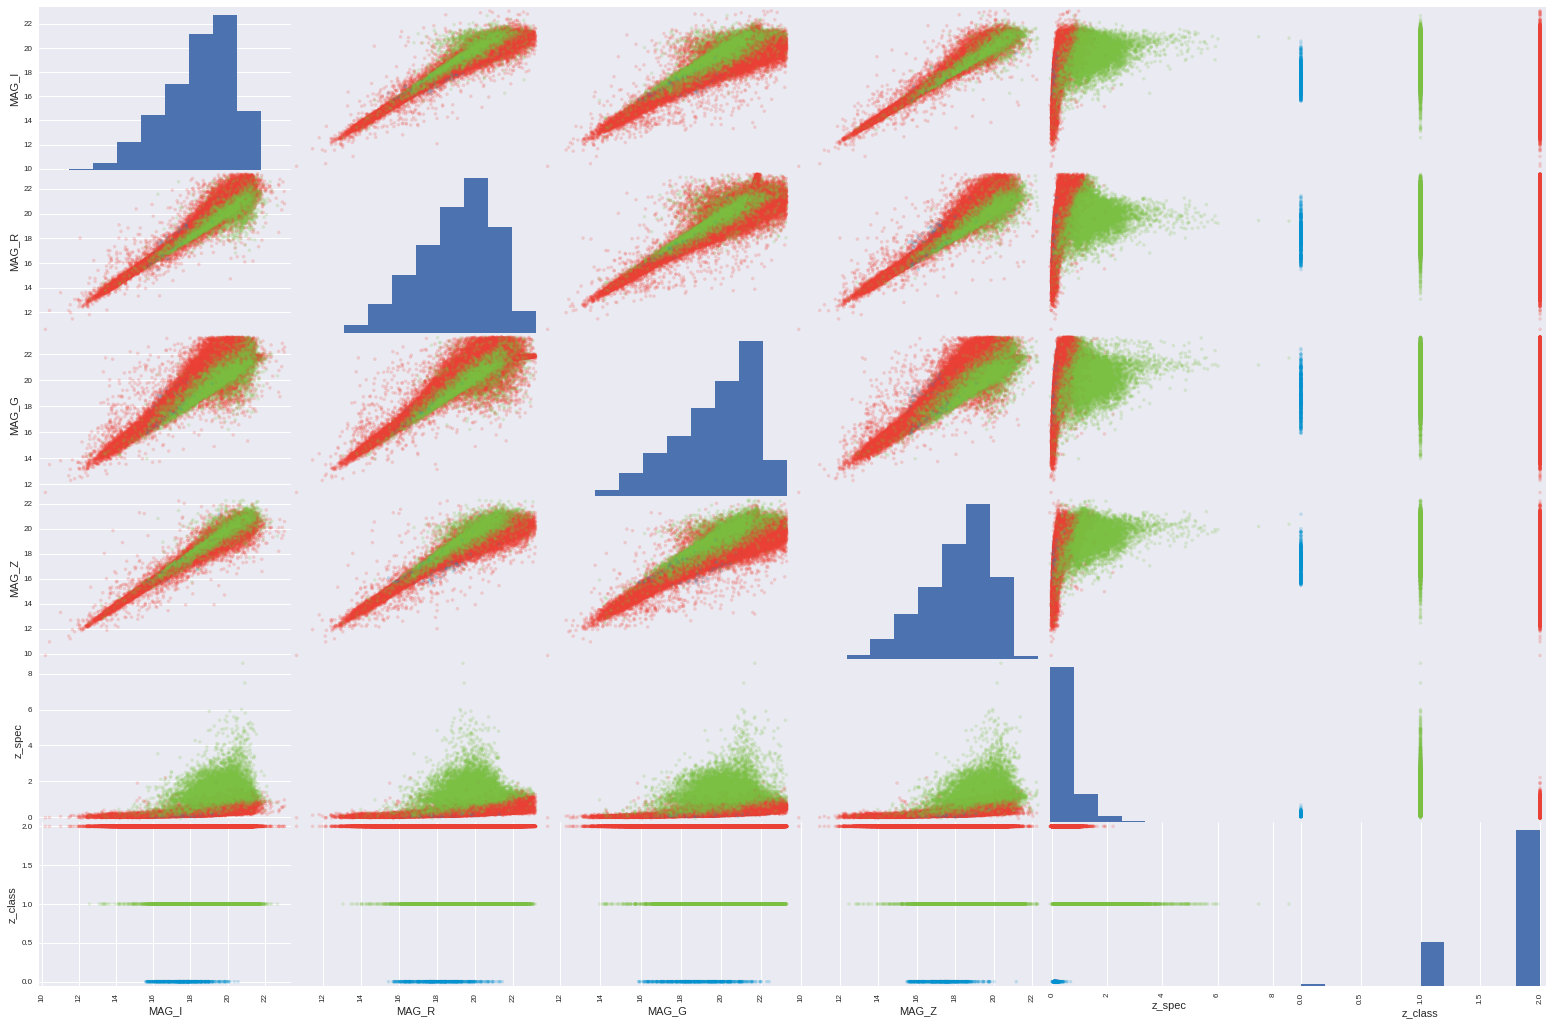

In [201]:
attributes = ["MAG_I","MAG_R","MAG_G","MAG_Z","z_spec","z_class"]
scatter_matrix(null_2[attributes],color = colors, figsize=(27,18),alpha = 0.2)

In [202]:
null_2["z_class"].value_counts()

2    50122
1    14028
0      499
Name: z_class, dtype: int64

Skymapper catalogue

In [203]:
sm_df

,col0,catalogue_id,n_components,flux_int,flux_peak,quality_level,SOURCEID_VISTA,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_U,MAG_G,MAG_R,MAG_I,MAG_Z,z_spec,spec_class,W1-W2,J-KS,KS-W1,U-G,G-R,R-Z,Z-J,G-RadioR,W2-RadioR
0,0,54,1,19.226921,16.343929,"b""b'UNCERTAIN '""",601340238219,18.024,17.441,18.542423,18.482422,9.999990e-01,18.5435,18.7459,18.7376,18.4589,18.771,NaN,<NA>,0.583000,0.060001,0.458422,-0.2024,0.0083,-0.0334,0.228577,-0.481021,-1.785920
1,2,1542,1,15.087712,15.005931,"b""b'NOT_VALIDATED'""",472906754566,15.582,15.717,15.234133,14.885287,1.714090e-04,18.2120,16.7960,16.2420,15.6850,15.393,0.062,1,-0.135000,0.348846,-0.696713,1.4160,0.5540,0.8490,0.158867,1.708288,0.629288
2,3,2301,2,8.276081,8.479472,"b""b'NOT_VALIDATED'""",473526124269,14.661,14.276,16.120893,15.419022,5.247814e-02,17.0460,16.6230,16.3430,16.4480,16.152,0.391,1,0.385000,0.701871,0.758022,0.4230,0.2800,0.1910,0.031107,8.346919,5.999919
3,5,833,1,15.417818,15.128676,"b""b'NOT_VALIDATED'""",473222782226,17.898,18.291,17.633600,17.159678,1.714090e-04,19.0457,19.1081,19.0369,18.5558,18.889,0.271,1,-0.392999,0.473922,-0.738322,-0.0624,0.0712,0.1479,1.255400,3.690282,2.873182
4,6,56,1,21.787255,18.053859,"b""b'UNCERTAIN '""",601335508306,17.344,16.853,17.825172,17.349025,5.292210e-07,18.7282,18.7101,18.5990,18.6970,18.840,NaN,<NA>,0.491001,0.476147,0.005025,0.0181,0.1111,-0.2410,1.014828,-3.077155,-4.934255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92008,259247,1484,1,15.057342,14.844983,"b""b'NOT_VALIDATED'""",472854980131,14.490,13.830,17.293708,15.488930,4.864865e-01,18.3960,17.9622,18.7550,17.8620,18.091,NaN,<NA>,0.660000,1.804778,0.998930,0.4338,-0.7928,0.6640,0.797292,2.904858,-1.227342
92009,259248,2345,1,16.244485,15.515209,"b""b'NOT_VALIDATED'""",473711165353,17.861,17.378,18.179733,17.616943,9.996572e-01,18.6293,18.2980,18.5060,18.4900,18.274,NaN,<NA>,0.483000,0.562790,-0.244057,0.3313,-0.2080,0.2320,0.094267,2.053515,1.133514
92010,259249,2758,1,16.405442,15.796757,"b""b'NOT_VALIDATED'""",472602670940,17.321,16.871,17.172320,17.063626,3.067485e-03,18.4003,18.3840,17.9780,17.6260,17.494,NaN,<NA>,0.450000,0.108694,-0.257374,0.0163,0.4060,0.4840,0.321680,1.978558,0.465557
92011,259250,3022,1,10.339086,10.395164,"b""b'NOT_VALIDATED'""",473409887073,14.105,13.830,14.990262,14.460981,9.996572e-01,17.5470,16.8830,16.6670,16.2140,15.993,NaN,<NA>,0.275000,0.529281,0.355981,0.6640,0.2160,0.6740,1.002738,6.543914,3.490914


In [204]:
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_U","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR","spec_class","z_spec"]
sm_df = sm_df[attributes]
df_sample = sm_df.dropna()
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_U","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
dataset = df_sample[attributes].to_numpy()

In [205]:
y_test = df_sample["z_spec"].values
dataset, y_test = dataset.astype("float"), y_test.astype("float")
n_features = dataset.shape[1]
X_train, X_test, y_train, y_test = train_test_split(dataset, y_test, test_size=0.33, random_state=1)

visible = Input(shape=(n_features,))
hidden1 = Dense(500, activation='relu', kernel_initializer='he_normal')(visible)
dropout1 = Dropout(0.2)(hidden1)
hidden3 = Dense(500, activation = "relu", kernel_initializer="he_normal")(dropout1)
dropout3 = Dropout(0.2)(hidden3)
hidden2 = Dense(500, activation='relu', kernel_initializer='he_normal')(dropout1)
dropout2 = Dropout(0.2)(hidden2)

out_reg = Dense(1, activation='linear')(dropout2)

model1 = Model(inputs=visible, outputs=[out_reg])

model1.compile(loss=['mse','sparse_categorical_crossentropy'], optimizer='adam')

In [206]:
model1.fit(X_train,y_train, epochs=300, batch_size=32, verbose=2)

Epoch 1/300
308/308 - 2s - loss: 40.2102
Epoch 2/300
308/308 - 2s - loss: 1.8668
Epoch 3/300
308/308 - 2s - loss: 0.3733
Epoch 4/300
308/308 - 2s - loss: 0.1694
Epoch 5/300
308/308 - 2s - loss: 0.1188
Epoch 6/300
308/308 - 1s - loss: 0.0973
Epoch 7/300
308/308 - 1s - loss: 0.0877
Epoch 8/300
308/308 - 2s - loss: 0.0755
Epoch 9/300
308/308 - 1s - loss: 0.0678
Epoch 10/300
308/308 - 1s - loss: 0.0668
Epoch 11/300
308/308 - 2s - loss: 0.0627
Epoch 12/300
308/308 - 1s - loss: 0.0642
Epoch 13/300
308/308 - 1s - loss: 0.0576
Epoch 14/300
308/308 - 1s - loss: 0.0546
Epoch 15/300
308/308 - 2s - loss: 0.0568
Epoch 16/300
308/308 - 2s - loss: 0.0556
Epoch 17/300
308/308 - 2s - loss: 0.0509
Epoch 18/300
308/308 - 2s - loss: 0.0521
Epoch 19/300
308/308 - 1s - loss: 0.0509
Epoch 20/300
308/308 - 2s - loss: 0.0497
Epoch 21/300
308/308 - 2s - loss: 0.0512
Epoch 22/300
308/308 - 2s - loss: 0.0498
Epoch 23/300
308/308 - 2s - loss: 0.0467
Epoch 24/300
308/308 - 2s - loss: 0.0479
Epoch 25/300
308/308 - 2

In [207]:
yhat1 = model1.predict(X_test)
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.051


In [208]:
reg = LinearRegression().fit(X_train,y_train)

yhat1 = reg.predict(X_test)

error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)

MAE: 0.088


In [209]:
df_sample

,flux_int,flux_peak,W1MAG,W2MAG,J_VISTA,KS_VISTA,PSTAR_VISTA,MAG_U,MAG_R,MAG_G,MAG_Z,W1-W2,J-KS,KS-W1,G-R,R-Z,Z-J,G-RadioR,W2-RadioR,spec_class,z_spec
1,15.087712,15.005931,15.582,15.717,15.234133,14.885287,0.000171,18.2120,16.2420,16.7960,15.3930,-0.135000,0.348846,-0.696713,0.5540,0.8490,0.158867,1.708288,0.629288,1,0.0620
2,8.276081,8.479472,14.661,14.276,16.120893,15.419022,0.052478,17.0460,16.3430,16.6230,16.1520,0.385000,0.701871,0.758022,0.2800,0.1910,0.031107,8.346919,5.999919,1,0.3910
3,15.417818,15.128676,17.898,18.291,17.633600,17.159678,0.000171,19.0457,19.0369,19.1081,18.8890,-0.392999,0.473922,-0.738322,0.0712,0.1479,1.255400,3.690282,2.873182,1,0.2710
6,11.733012,11.823480,17.985,17.963,18.427791,18.100882,0.999981,18.2512,18.2363,18.7200,18.1940,0.022001,0.326909,0.115882,0.4837,0.0423,-0.233791,6.986988,6.229988,1,3.0460
7,14.791615,15.142908,16.441,16.106,17.142910,16.910446,0.052478,17.7150,17.2960,17.4740,17.3010,0.334999,0.232464,0.469447,0.1780,-0.0050,0.158090,2.682385,1.314385,1,0.7230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91997,12.006168,12.000925,18.121,17.995,18.133617,18.105414,0.999657,18.5209,18.0718,18.7780,17.8490,0.126000,0.028203,-0.015586,0.7062,0.2228,-0.284617,6.771832,5.988832,1,2.6340
91998,21.514394,17.862567,18.026,17.203,19.003582,18.570120,0.999819,20.3443,18.0706,18.6027,17.4932,0.822999,0.433462,0.544120,0.5321,0.5774,-1.510382,-2.911694,-4.311393,1,1.3218
92000,13.113121,13.132223,16.787,16.525,17.724560,17.162191,0.999981,18.6339,18.1782,18.3550,18.2290,0.262000,0.562369,0.375191,0.1768,-0.0508,0.504440,5.241879,3.411879,1,0.5640
92001,11.578844,12.868261,17.047,16.629,18.276413,17.892172,0.000171,18.5534,18.6255,18.6740,18.5100,0.418000,0.384241,0.845172,0.0485,0.1155,0.233587,7.095156,5.050156,1,0.5860


In [210]:
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_U","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
df_sample["z_spec_1"] = model1.predict(df_sample[attributes].to_numpy())
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_U","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
dataset = df_sample[attributes].to_numpy()

y_class = df_sample["spec_class"].values 
n_class = len(unique(y_class))
dataset,  y_class = dataset.astype('float'),y_class.astype("int")

n_features = dataset.shape[1]
X_train, X_test, y_train_class, y_test_class = train_test_split(dataset, y_class, test_size=0.33, random_state=1)

sampling_strategy_  = {0: 2000,
                      1: 4000,
                      2: 8831}
ros = RandomOverSampler(random_state=42,sampling_strategy=sampling_strategy_)
X_train, y_train_class = ros.fit_resample(X_train, y_train_class)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [211]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train_class)
yhat2 = clf.predict(X_test)

confusion_matrix(y_test_class,yhat2)

array([[  26,    1,    5],
       [   0,  279,  159],
       [   1,  167, 4213]])

In [212]:
null_3 = sm_df[des_df["z_spec"].isnull()]
attributes = ["flux_int","flux_peak","W1MAG","W2MAG","J_VISTA","KS_VISTA","PSTAR_VISTA","MAG_U","MAG_R","MAG_G","MAG_Z","W1-W2","J-KS","KS-W1","G-R","R-Z","Z-J","G-RadioR","W2-RadioR"]
null_3 = null_3[attributes]

predicted_redshifts = model1.predict(null_3.values)

null_3["z_spec"] = predicted_redshifts

predicted_classes = clf.predict(null_3[attributes].values)

null_3["z_class"] = predicted_classes

color_wheel = {0: "#0392cf", #blue Star
               1: "#7bc043", #green AGN
               2: "#ee4035"} #red Galaxy
colors = null_3["z_class"].map(lambda x: color_wheel.get(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f92a13e5990>,
      dtype=object)

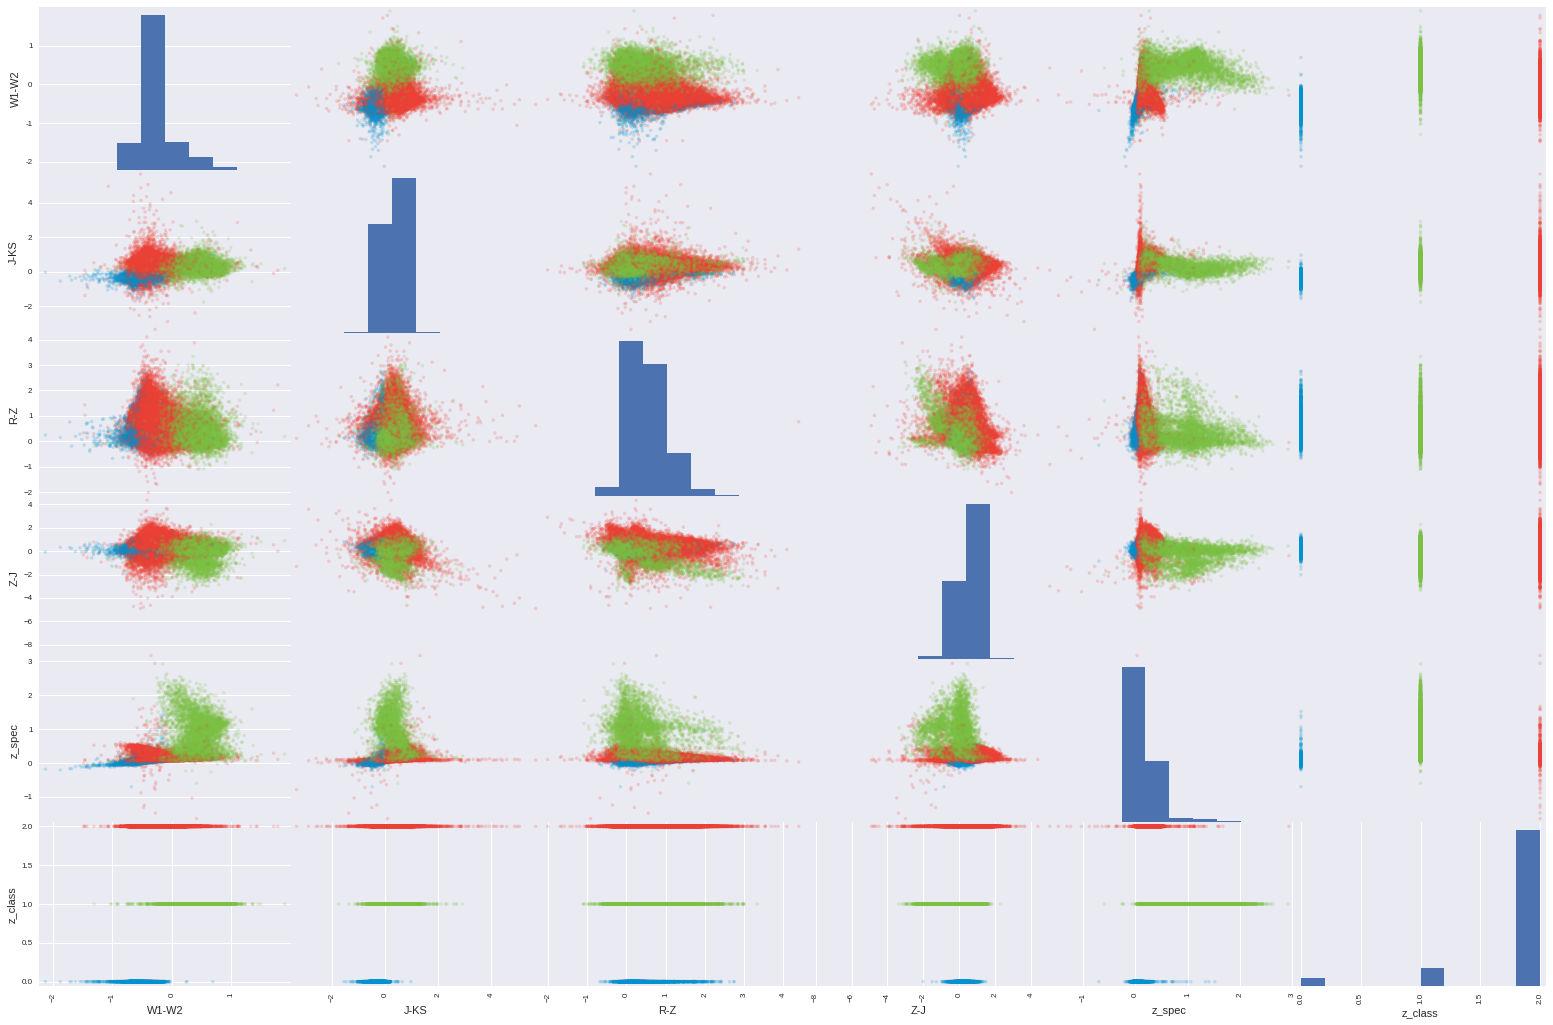

In [213]:
attributes = ["W1-W2","J-KS","R-Z","Z-J","z_spec","z_class"]
scatter_matrix(null_3[attributes],color = colors, figsize=(27,18),alpha = 0.2)

In [214]:
null_3["z_class"].value_counts()

2    73025
1     8193
0     3564
Name: z_class, dtype: int64

(array([2.0059e+04, 3.2847e+04, 3.0610e+03, 1.4080e+03, 5.2800e+02,
        9.2000e+01, 3.9000e+01, 9.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([-0.19810575,  0.31058952,  0.8192848 ,  1.32798   ,  1.8366753 ,
         2.3453705 ,  2.854066  ,  3.362761  ,  3.8714564 ,  4.3801517 ,
         4.888847  ], dtype=float32),
 <a list of 10 Patch objects>)

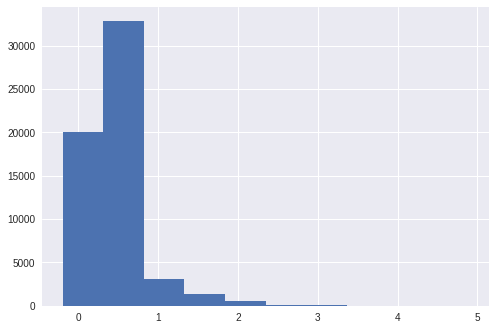

In [215]:
plt.hist(null_1["z_spec"].values)

(array([5.2503e+04, 9.5400e+03, 2.0370e+03, 4.1200e+02, 9.5000e+01,
        4.4000e+01, 1.5000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-0.07409637,  0.7916511 ,  1.6573987 ,  2.5231462 ,  3.3888936 ,
         4.254641  ,  5.1203885 ,  5.9861364 ,  6.851884  ,  7.7176313 ,
         8.583379  ], dtype=float32),
 <a list of 10 Patch objects>)

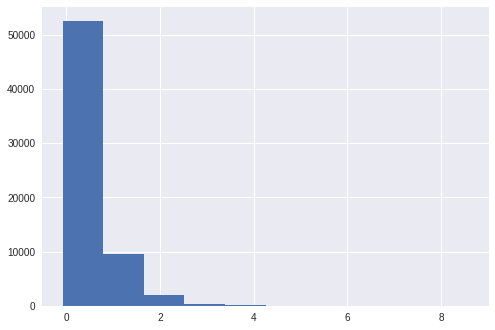

In [216]:
plt.hist(null_2["z_spec"].values)

(array([4.0000e+00, 4.0000e+00, 1.2000e+01, 5.8299e+04, 2.2981e+04,
        1.7550e+03, 1.1830e+03, 4.0400e+02, 1.3200e+02, 8.0000e+00]),
 array([-1.6424794 , -1.1838232 , -0.72516704, -0.26651084,  0.19214535,
         0.65080154,  1.1094577 ,  1.5681139 ,  2.02677   ,  2.4854264 ,
         2.9440825 ], dtype=float32),
 <a list of 10 Patch objects>)

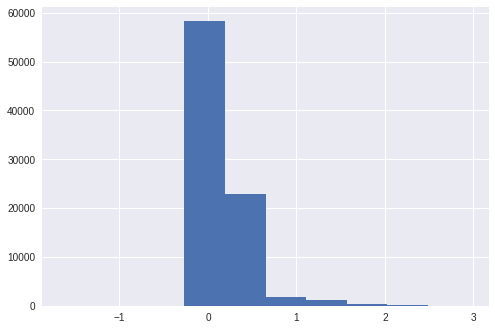

In [217]:
plt.hist(null_3["z_spec"].values)

Luminosity


PS


In [218]:
limit_flux = 0.75  # mJy, 3 x 0.25 mJy
alpha = -0.8

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70*u.km/u.s/u.Mpc,Tcmb0 = 2.725*u.K,Om0=0.3)

In [219]:
radio_flux_AB = null_1['flux_int'].copy().values * u.ABmag
radio_flux_mJy = radio_flux_AB.to(u.mJy)  #1mJy = 1e-29 Wm-2Hz-1
red = null_1['z_spec'].copy().values

null_1['flux_int_mJy'] = radio_flux_mJy.value

filter_PS = np.array(null_1.loc[:, 'flux_int_mJy'] >= limit_flux) &\
                 np.array(null_1.loc[:, 'z_class'] != 0)

ps_with_L = null_1.loc[filter_PS]
lum_dist = cosmo.luminosity_distance(ps_with_L.loc[:,'z_spec']).to(u.m).value

radio_flx_PS_14  = (ps_with_L.loc[:, 'flux_int'].to_numpy() * u.mag(u.AB)).to(u.mJy) * (1.4e9/887.5e6)**alpha

luminosity_PS   = 4 * np.pi * lum_dist**2 * radio_flx_PS_14 * 1e-3  * 1e-26 /\
                     (1 + ps_with_L.loc[:, 'z_spec'])**(1 + alpha)  # in W/Hz

ps_with_L['luminosity'] = luminosity_PS
ps_with_L['dist'] = lum_dist
ps_with_L['flux_int_mJy_14'] = radio_flx_PS_14

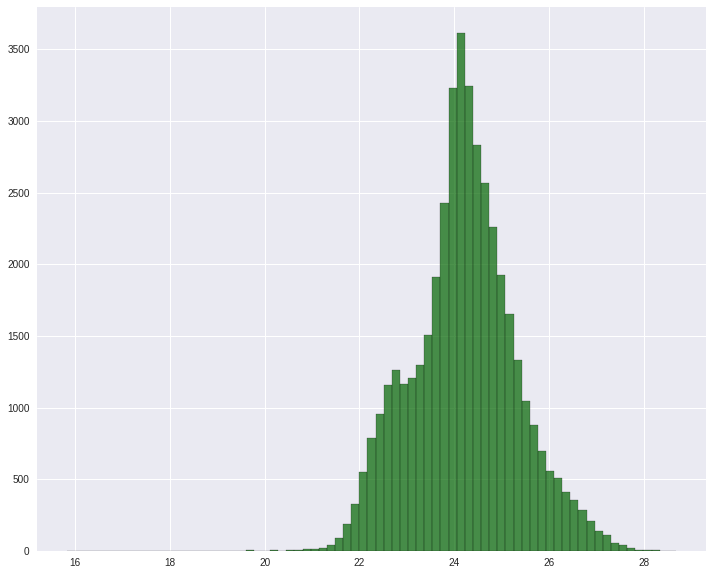

In [220]:
fig             = plt.figure(figsize=(12,10))

plt.hist(np.array(np.log10(ps_with_L['luminosity'])),bins=75,color = 'DarkGreen',ec='black',alpha =0.7)
plt.show()

In [221]:
t = 0
tot = 0

for i in range(len(np.array(ps_with_L['z_class']))):
  if np.array(ps_with_L['z_class'])[i] == 2 and np.array(ps_with_L['luminosity'])[i] > 1e25:
    t+=1
    tot +=1
  elif np.array(ps_with_L['z_class'])[i] == 2:
    tot+=1

trueperc = t/tot

print(trueperc)

0.1345457808620741


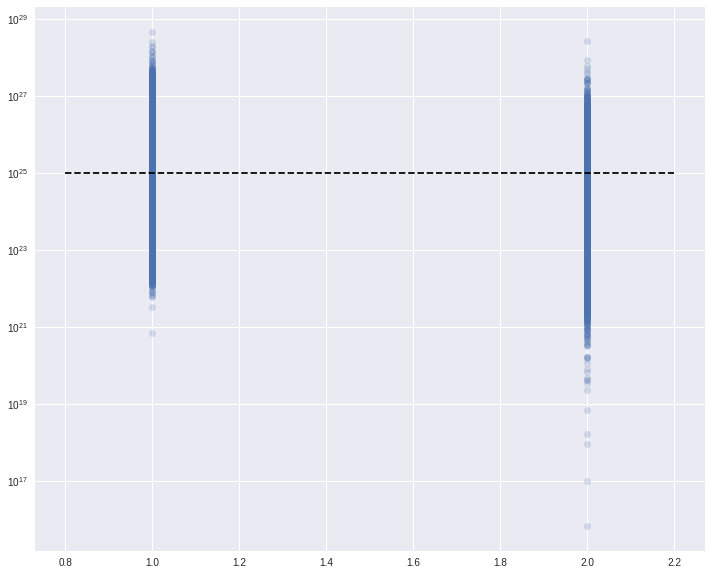

In [222]:
fig             = plt.figure(figsize=(12,10))

plt.plot(np.array(ps_with_L['z_class']),np.array(ps_with_L['luminosity']),marker='o',ls='',alpha=0.2)
plt.yscale('log')
plt.plot([0.8,1,2,2.2],[1e25,1e25,1e25,1e25], ls='--',color = 'black')
plt.show()

In [223]:
ps_with_L_changed = ps_with_L.copy()

filt_class_lum_PS = np.array(ps_with_L_changed['luminosity'] > 1e25)

ps_with_L_changed.loc[:, 'z_class'].mask(filt_class_lum_PS, other=1, inplace=True)

DES

In [224]:
radio_flux_AB = null_2['flux_int'].copy().values * u.ABmag
radio_flux_mJy = radio_flux_AB.to(u.mJy)  #1mJy = 1e-29 Wm-2Hz-1
red = null_2['z_spec'].copy().values

null_2['flux_int_mJy'] = radio_flux_mJy.value

filter_PS = np.array(null_2.loc[:, 'flux_int_mJy'] >= limit_flux) &\
                 np.array(null_2.loc[:, 'z_class'] != 0)

ps_with_L = null_2.loc[filter_PS]
lum_dist = cosmo.luminosity_distance(ps_with_L.loc[:,'z_spec']).to(u.m).value

radio_flx_PS_14  = (ps_with_L.loc[:, 'flux_int'].to_numpy() * u.mag(u.AB)).to(u.mJy) * (1.4e9/887.5e6)**alpha

luminosity_PS   = 4 * np.pi * lum_dist**2 * radio_flx_PS_14 * 1e-3  * 1e-26 /\
                     (1 + ps_with_L.loc[:, 'z_spec'])**(1 + alpha)  # in W/Hz

ps_with_L['luminosity'] = luminosity_PS
ps_with_L['dist'] = lum_dist
ps_with_L['flux_int_mJy_14'] = radio_flx_PS_14

In [225]:
t = 0
tot = 0

for i in range(len(np.array(ps_with_L['z_class']))):
  if np.array(ps_with_L['z_class'])[i] == 2 and np.array(ps_with_L['luminosity'])[i] > 1e25:
    t+=1
    tot +=1
  elif np.array(ps_with_L['z_class'])[i] == 2:
    tot+=1

trueperc = t/tot

print(trueperc)

0.1085254862419402


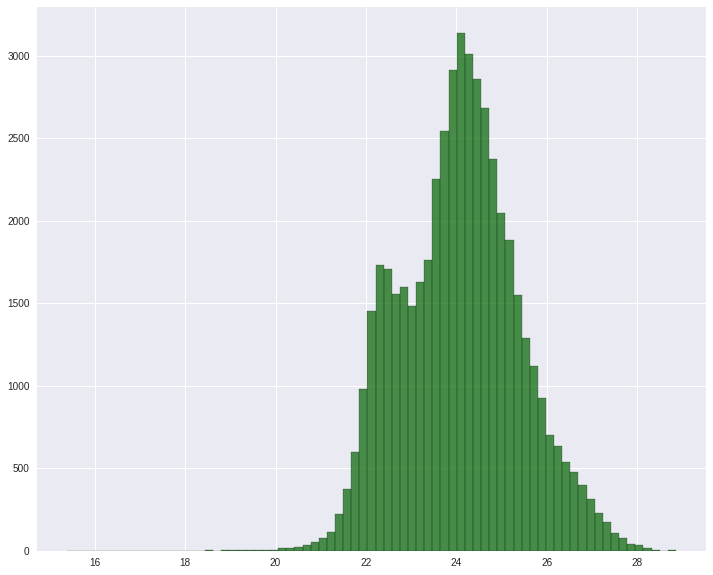

In [226]:
fig             = plt.figure(figsize=(12,10))

plt.hist(np.array(np.log10(ps_with_L['luminosity'])),bins=75,color = 'DarkGreen',ec='black',alpha =0.7)
plt.show()

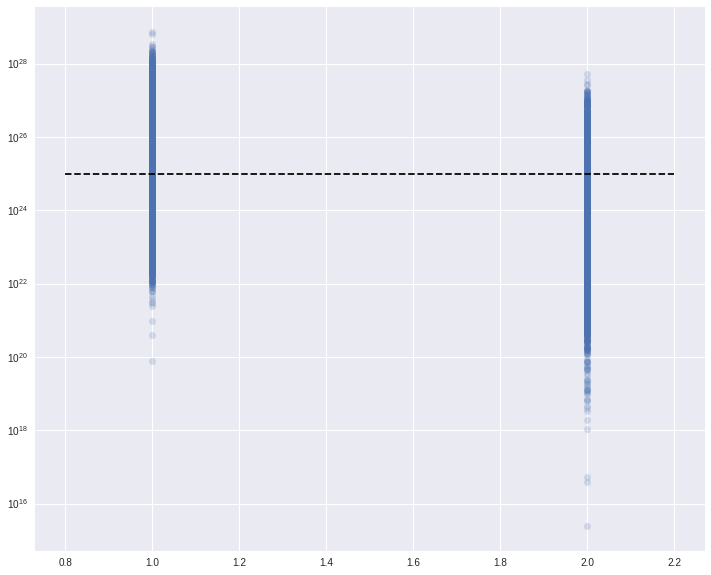

In [227]:
fig             = plt.figure(figsize=(12,10))

plt.plot(np.array(ps_with_L['z_class']),np.array(ps_with_L['luminosity']),marker='o',ls='',alpha=0.2)
plt.yscale('log')
plt.plot([0.8,1,2,2.2],[1e25,1e25,1e25,1e25], ls='--',color = 'black')
plt.show()

In [228]:
radio_flux_AB = null_3['flux_int'].copy().values * u.ABmag
radio_flux_mJy = radio_flux_AB.to(u.mJy)  #1mJy = 1e-29 Wm-2Hz-1
red = null_3['z_spec'].copy().values

null_3['flux_int_mJy'] = radio_flux_mJy.value

filter_PS = np.array(null_3.loc[:, 'flux_int_mJy'] >= limit_flux) &\
                 np.array(null_3.loc[:, 'z_class'] != 0)

ps_with_L = null_3.loc[filter_PS]
lum_dist = cosmo.luminosity_distance(ps_with_L.loc[:,'z_spec']).to(u.m).value

radio_flx_PS_14  = (ps_with_L.loc[:, 'flux_int'].to_numpy() * u.mag(u.AB)).to(u.mJy) * (1.4e9/887.5e6)**alpha

luminosity_PS   = 4 * np.pi * lum_dist**2 * radio_flx_PS_14 * 1e-3  * 1e-26 /\
                     (1 + ps_with_L.loc[:, 'z_spec'])**(1 + alpha)  # in W/Hz

ps_with_L['luminosity'] = luminosity_PS
ps_with_L['dist'] = lum_dist
ps_with_L['flux_int_mJy_14'] = radio_flx_PS_14

In [229]:
t = 0
tot = 0

for i in range(len(np.array(ps_with_L['z_class']))):
  if np.array(ps_with_L['z_class'])[i] == 2 and np.array(ps_with_L['luminosity'])[i] > 1e25:
    t+=1
    tot +=1
  elif np.array(ps_with_L['z_class'])[i] == 2:
    tot+=1

trueperc = t/tot

print(trueperc)

0.021027648234510327


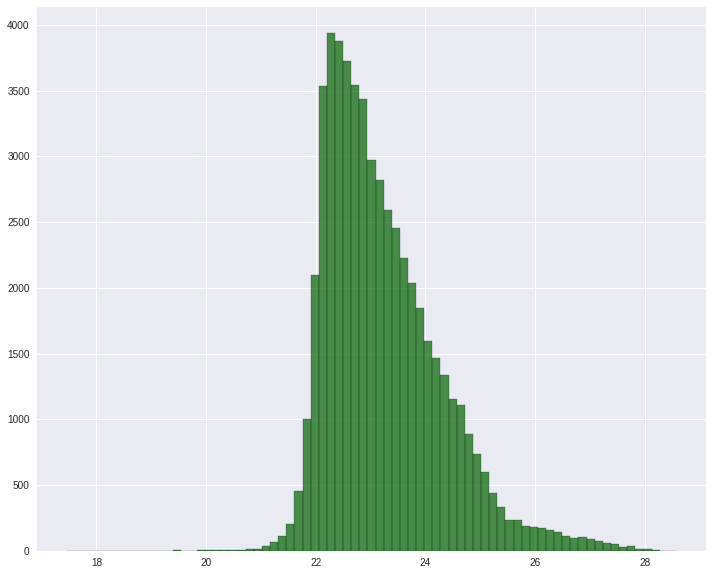

In [230]:
fig             = plt.figure(figsize=(12,10))

plt.hist(np.array(np.log10(ps_with_L['luminosity'])),bins=75,color = 'DarkGreen',ec='black',alpha =0.7)
plt.show()

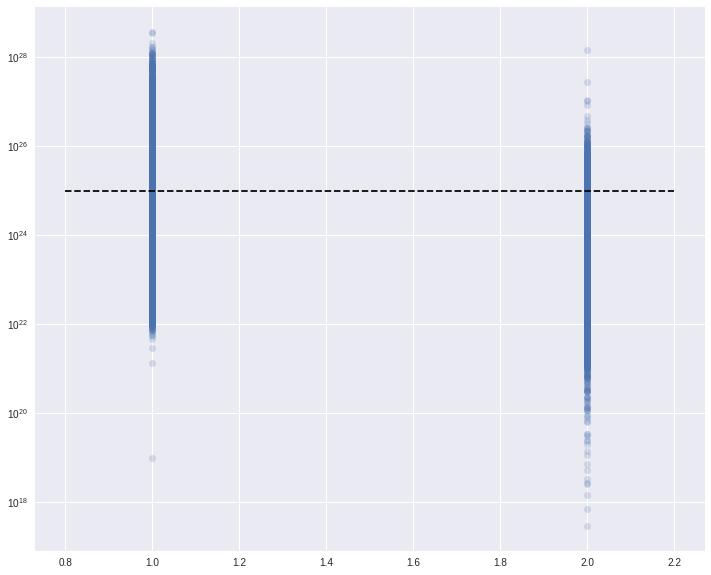

In [231]:
fig             = plt.figure(figsize=(12,10))

plt.plot(np.array(ps_with_L['z_class']),np.array(ps_with_L['luminosity']),marker='o',ls='',alpha=0.2)
plt.yscale('log')
plt.plot([0.8,1,2,2.2],[1e25,1e25,1e25,1e25], ls='--',color = 'black')
plt.show()